# 조강(닭목, 타조목, 수리목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [76]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [2]:
def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k

## k_gc값 변화에 따른 데이터 분포 그래프 그리기

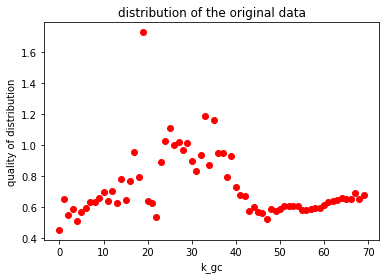

In [4]:
def setGC(filename, index):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    l = []
    for record in file:
        l.append(len(record.seq))
    k_gc = min(l)
    k_gc += index
    #print(k_gc)
    return k_gc
    #[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

def creMaxGCDf(filename, k_gc):
    import pandas as pd
    import numpy as np
    
    gc_df = pd.DataFrame()
    gc_df['start index'] = 0
    gc_df['gc-contents'] = 0

    file = SeqIO.parse(filename, 'fasta')

    for i, record in enumerate(file):
        index = 0
        gc_rates = []
        while(index + k_gc <= len(record.seq)):
            mer = record.seq[index:index + k_gc]
            gc_rates.append(GC(mer))
            index += 1
        if(index == 0):
            gc_rates.append(GC(record.seq))
        gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
        gc_df.loc[i, 'gc-contents'] = max(gc_rates)
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장
    return gc_df

def creDf(filename, gc_df, k_gc):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    k = 3
    dict = {}
    df = pd.DataFrame()

    #[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
    base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
    'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

    #[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
    def init(datatype):
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
        #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
        datatype['GC-contents'] = 0
        datatype['target'] = 0
        
    init(df)

    for i, record in enumerate(file):
        init(dict)
        record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
        #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
        dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
        #[220805_1025]CREATED 최대 GC 값 저장
        dict['target'] = getGenbank(record.id).organism
        
        index = 0
        
        if(len(record.seq) >= k):
            while(index + k <= len(record.seq)):
                mer = record.seq[index:index + k]
                for p in range(k):
                    mer = mer.replace(mer[p], base_dict.get(mer[p]))
                dict[mer] += 1
                index += 1
        df.loc[i] = dict
    return df

def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k



import matplotlib.pyplot as plt
import numpy as np

index = 0
filename = 'all_aves_coi.fasta'

sil_ratios = []

for i in range(0, 700, 10):
    k_gc = setGC(filename, i)
    gc_df = creMaxGCDf(filename, k_gc)
    df = creDf(filename, gc_df, k_gc)
    sil_ratios.append(calSilhouette(df))

plt.plot(np.arange(0, 70), sil_ratios, 'ro')
plt.title('distribution of the original data')
plt.xlabel('k_gc')
plt.ylabel('quality of distribution')
plt.show()
plt.close()

In [18]:
calSilhouette(df)

1.1136774987688491

In [2]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220818_0805]CREATED 조강 닭, 타조, 수리목에 속하는 9종 선정
species = ['Gallus gallus', 'Callipepla californica', 'Numida meleagris', 
           'Apteryx australis', 'Rhea americana', 'Apteryx owenii', 
           'Haliaeetus leucocephalus', 'Aquila chrysaetos', 'Pithecophaga jefferyi']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating MZ402653.1.fasta...
## creating MZ050504.1.fasta...
## creating MZ050503.1.fasta...
## creating MZ050502.1.fasta...
## creating MN124253.1.fasta...
## creating MN018224.1.fasta...
## creating MN018223.1.fasta...
## creating MN018222.1.fasta...
## creating MN018221.1.fasta...
## creating MN018220.1.fasta...
## creating MN018219.1.fasta...
## creating MN018218.1.fasta...
## creating MN018217.1.fasta...
## creating MN018216.1.fasta...
## creating MN018215.1.fasta...
## creating MN018214.1.fasta...
## creating MN018213.1.fasta...
## creating MN018212.1.fasta...
## creating MN018211.1.fasta...
## creating W66566.1.fasta...
## creating MH814474.1.fasta...
## creating MH814473.1.fasta...
## creating MH814472.1.fasta...
## creating MH814471.1.fasta...
## creating MH814470.1.fasta...
## creating MH814469.1.fasta...
## creating MH814468.1.fasta...
## creating MH814467.1.fasta...
## creating MH814466.1.fasta...
## creating MH814465.1.fasta...
## creating MH814464.1.fasta...
## creatin

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [77]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_aves_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
k_gc += 250
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_aves_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    if(index == 0):
        gc_rates.append(GC(record.seq))
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

386


### 기존 데이터 슬라이싱 후 3-mer 적용

In [78]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_aves_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [50]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Aquila chrysaetos', 'Haliaeetus leucocephalus',
       'Callipepla californica', 'Gallus gallus', 'Apteryx owenii',
       'Pithecophaga jefferyi', 'Rhea americana', 'Numida meleagris',
       'Apteryx australis'], dtype=object)

In [51]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[2 5 2 3 2 5 5 5 5 4 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 3 4 4 2 2 2 2 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 4 4 4 4 4 4 4 8 8 4 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 1 1 0 0 1 0
 0 1 0 0 0 0 1 3 0 0 0 1 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 4 3 4 4 4 4 5 4]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,52.590674,2
1,3,1,9,6,3,6,10,3,8,3,...,10,6,12,8,5,2,9,2,51.813472,5
2,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,52.590674,2
3,4,1,9,2,2,2,6,2,6,1,...,10,3,17,9,5,5,11,3,51.554404,3
4,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,52.590674,2


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [9]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,0.909534,2
1,3,1,9,6,3,6,10,3,8,3,...,10,6,12,8,5,2,9,2,0.875610,5
2,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,0.909534,2
3,4,1,9,2,2,2,6,2,6,1,...,10,3,17,9,5,5,11,3,0.864301,3
4,4,1,11,2,3,3,9,1,11,1,...,6,3,12,11,9,0,9,3,0.909534,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3,1,7,2,3,5,10,2,8,1,...,9,2,14,7,9,0,9,6,0.886918,4
271,3,2,5,8,5,3,12,4,9,2,...,5,6,9,8,8,0,9,7,0.875610,4
272,3,1,7,2,3,5,10,2,8,1,...,9,2,14,7,10,0,9,6,0.875610,4
273,3,1,8,5,4,3,9,3,10,0,...,9,2,12,12,7,2,8,5,0.785144,5


In [10]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 그냥 했을 때

In [52]:
calSilhouette(df)

1.1095968037755675

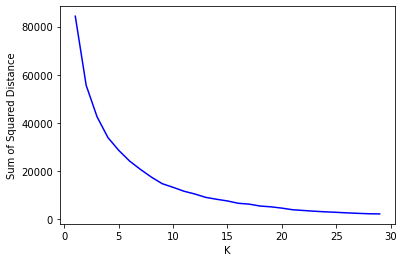

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df.loc[:, :'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.loc[:, :'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:, :'GC-contents'], df['cluster'])
    sil_tot = silhouette_score(df.loc[:, :'GC-contents'], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.439
군집 별 실루엣 계수 평균: 
cluster
0    0.540095
1    0.212773
Name: sil_sam, dtype: float64
score: 0.164
---------------
전체 실루엣 계수 평균: 0.467
군집 별 실루엣 계수 평균: 
cluster
0    0.490996
1    0.636083
2    0.348619
Name: sil_sam, dtype: float64
score: 0.104
---------------
전체 실루엣 계수 평균: 0.462
군집 별 실루엣 계수 평균: 
cluster
0    0.266893
1    0.586716
2    0.328030
3    0.636083
Name: sil_sam, dtype: float64
score: 0.157
---------------
전체 실루엣 계수 평균: 0.511
군집 별 실루엣 계수 평균: 
cluster
0    0.924912
1    0.321115
2    0.729899
3    0.305672
4    0.636083
Name: sil_sam, dtype: float64
score: 0.231
---------------
전체 실루엣 계수 평균: 0.525
군집 별 실루엣 계수 평균: 
cluster
0    0.924912
1    0.305672
2    0.371163
3    0.629500
4    0.729848
5    0.714721
Name: sil_sam, dtype: float64
score: 0.212
---------------
전체 실루엣 계수 평균: 0.531
군집 별 실루엣 계수 평균: 
cluster
0    0.482253
1    0.729045
2    0.623025
3    0.351436
4    0.305633
5    0.924912
6    0.697975
Name: sil_sam, dtype: float64
score: 0.186
--------------

In [55]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [66]:
km = KMeans(n_clusters = 11, max_iter = 1000)
km.fit(df.loc[:, :'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8625340708674042

In [57]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8,9,10
target,,,,,,,,,,,
0,0,0,0,0,12,0,0,0,0,0,0
1,0,0,0,0,8,0,0,0,0,0,1
2,0,3,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,9,0,0
4,0,0,60,19,0,66,2,18,0,0,11
5,0,19,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,8,0
7,31,0,0,0,0,0,0,0,0,0,0
8,0,2,0,0,0,0,0,0,0,0,0


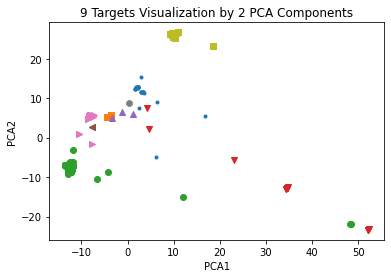

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

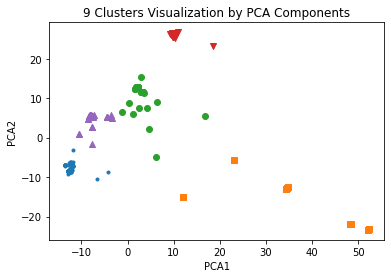

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by PCA Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572

### PCA 차원축소 사용했을 때

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit_transform(df.loc[:,:'GC-contents'])

df['pca_x'] = pca[:, 0]
df['pca_y'] = pca[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,4,1,11,2,3,3,9,1,11,1,...,11,9,0,9,3,52.590674,2,6,-2.242231,-2.007107
1,3,1,9,6,3,6,10,3,8,3,...,8,5,2,9,2,51.813472,5,2,8.529145,-8.929155
2,4,1,11,2,3,3,9,1,11,1,...,11,9,0,9,3,52.590674,2,6,-2.242231,-2.007107
3,4,1,9,2,2,2,6,2,6,1,...,9,5,5,11,3,51.554404,3,8,1.018798,-6.330648
4,4,1,11,2,3,3,9,1,11,1,...,11,9,0,9,3,52.590674,2,6,-2.242231,-2.007107


In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['pca_x', 'pca_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['pca_x', 'pca_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

0.012250110951251204


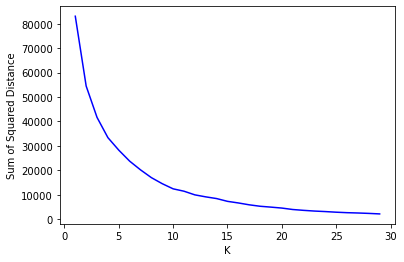

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df.loc[:, :'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['pca_x', 'pca_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['pca_x', 'pca_y']], df['cluster'])
    sil_tot = silhouette_score(df[['pca_x', 'pca_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.629
군집 별 실루엣 계수 평균: 
cluster
0    0.699965
1    0.471631
Name: sil_sam, dtype: float64
score: 0.114
---------------
전체 실루엣 계수 평균: 0.670
군집 별 실루엣 계수 평균: 
cluster
0    0.642034
1    0.740713
2    0.706195
Name: sil_sam, dtype: float64
score: 0.045
---------------
전체 실루엣 계수 평균: 0.661
군집 별 실루엣 계수 평균: 
cluster
0    0.664594
1    0.654861
2    0.705687
3    0.646571
Name: sil_sam, dtype: float64
score: 0.017
---------------
전체 실루엣 계수 평균: 0.673
군집 별 실루엣 계수 평균: 
cluster
0    0.768972
1    0.651869
2    0.776752
3    0.643457
4    0.401222
Name: sil_sam, dtype: float64
score: 0.104
---------------
전체 실루엣 계수 평균: 0.750
군집 별 실루엣 계수 평균: 
cluster
0    0.498209
1    0.401222
2    0.769004
3    0.913442
4    0.856326
5    0.776752
Name: sil_sam, dtype: float64
score: 0.153
---------------
전체 실루엣 계수 평균: 0.768
군집 별 실루엣 계수 평균: 
cluster
0    0.854842
1    0.780827
2    0.776752
3    0.745411
4    0.913442
5    0.398850
6    0.300636
Name: sil_sam, dtype: float64
score: 0.159
--------------

In [70]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [75]:
km = KMeans(n_clusters = 7, max_iter = 1000)
km.fit(df.loc[:, :'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8532748116081449

In [13]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4
target,,,,,
0,12,0,0,0,0
1,8,0,0,1,0
2,3,0,0,4,0
3,0,0,0,9,0
4,14,129,16,7,10
5,19,0,0,2,0
6,0,0,0,8,0
7,0,0,0,31,0
8,2,0,0,0,0


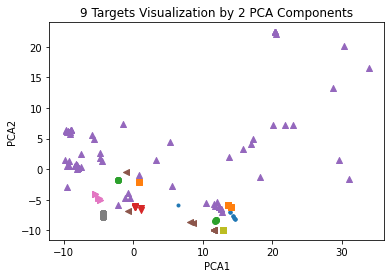

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

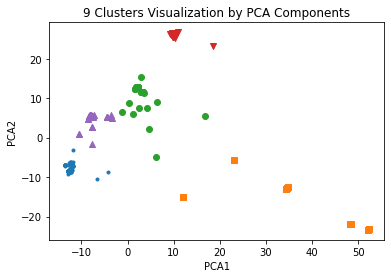

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by PCA Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572

### LDA 차원축소 사용했을 때

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'GC-contents'], df['target'])
ma_lda = lda.transform(df.loc[:, :'GC-contents'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(275, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTG,TTC,TTT,GC-contents,target,sil_sam,pca_x,pca_y,lda_x,lda_y
0,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-0.469921,-2.147720,-1.747361,-28.805129,-22.068587
1,3,1,9,6,3,6,10,3,8,3,...,2,9,2,0.875610,5,0.138551,8.652881,-8.850602,-19.726247,13.588622
2,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-0.469921,-2.147720,-1.747361,-28.805129,-22.068587
3,4,1,9,2,2,2,6,2,6,1,...,5,11,3,0.864301,3,0.857667,1.095917,-6.392482,-148.848158,-25.770755
4,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-0.469921,-2.147720,-1.747361,-28.805129,-22.068587


In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['lda_x', 'lda_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['lda_x', 'lda_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

23.08561898732783


In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df[['lda_x', 'lda_y']]
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1, 'gamma': 1}
0.9954545454545455
오차 행렬
[[ 3  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  7  0]
 [ 1  0  0  0  0  0  0  0  0]]
정확도: 0.98, 정밀도: 0.86, 재현율: 0.89


/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


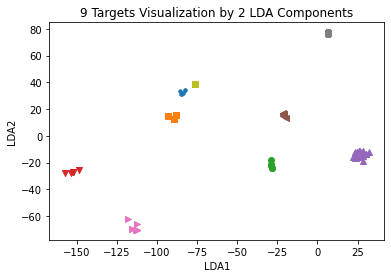

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'lda_x'], y = df.loc[j, 'lda_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

### t-sne 차원축소 사용했을 때

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:,:'GC-contents'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTG,TTC,TTT,GC-contents,target,pca_x,pca_y,cluster,tsne_x,tsne_y
0,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-2.147720,-1.747361,3,-1.190894,5.508413
1,3,1,9,6,3,6,10,3,8,3,...,2,9,2,0.875610,5,8.652881,-8.850602,0,12.520181,-2.549967
2,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-2.147720,-1.747361,3,-1.190787,5.508430
3,4,1,9,2,2,2,6,2,6,1,...,5,11,3,0.864301,3,1.095917,-6.392482,3,4.757103,11.503814
4,4,1,11,2,3,3,9,1,11,1,...,0,9,3,0.909534,2,-2.147720,-1.747361,3,-1.191096,5.508379


In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

0.07914817503153092


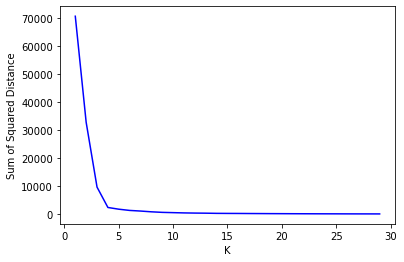

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.636
군집 별 실루엣 계수 평균: 
cluster
0    0.591671
1    0.981583
Name: sil_sam, dtype: float32
score: 0.195
---------------
전체 실루엣 계수 평균: 0.686
군집 별 실루엣 계수 평균: 
cluster
0    0.790974
1    0.570723
2    0.981507
Name: sil_sam, dtype: float32
score: 0.172
---------------
전체 실루엣 계수 평균: 0.766
군집 별 실루엣 계수 평균: 
cluster
0    0.715507
1    0.754798
2    0.977659
3    0.749573
Name: sil_sam, dtype: float32
score: 0.072
---------------
전체 실루엣 계수 평균: 0.702
군집 별 실루엣 계수 평균: 
cluster
0    0.557217
1    0.707247
2    0.977659
3    0.748426
4    0.559006
Name: sil_sam, dtype: float32
score: 0.123
---------------
전체 실루엣 계수 평균: 0.661
군집 별 실루엣 계수 평균: 
cluster
0    0.722956
1    0.651350
2    0.559006
3    0.973996
4    0.589696
5    0.557217
Name: sil_sam, dtype: float32
score: 0.110
---------------
전체 실루엣 계수 평균: 0.665
군집 별 실루엣 계수 평균: 
cluster
0    0.588652
1    0.559006
2    0.759648
3    0.973996
4    0.557217
5    0.651350
6   -0.013177
Name: sil_sam, dtype: float32
score: 0.198
--------------

In [17]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [18]:
km = KMeans(n_clusters = 4, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8742484367484367

In [19]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3
target,,,,
0,0,12,0,0
1,0,9,0,0
2,0,3,0,4
3,0,0,0,9
4,69,40,0,67
5,1,19,0,1
6,0,0,0,8
7,0,0,31,0
8,0,2,0,0


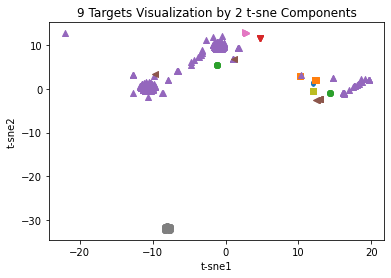

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('t-sne1')
plt.ylabel('t-sne2')
plt.title('9 Targets Visualization by 2 t-sne Components')
plt.show()

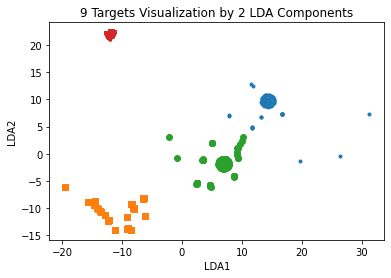

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

In [31]:
km2 = KMeans(n_clusters = 4, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.8742484367484367